<a href="https://colab.research.google.com/github/yongtaoliu/Ferroelectric-wall-dynamics-and-pinning-mechanisms/blob/main/Ferroelectric_DW_dynamics_Notebook1B_DCNN_for_Domain_Wall_Finding_NoGroupHED_TrainDataEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCNN for Domain Walls Finding**

May, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
*   Workflow by Tommy Wong and modified by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
*   Training realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
*   Interferometric Displacement Sensor (IDS) PFM data on PZT by [Roger Proskch](https://scholar.google.com/citations?user=8OjHap0AAAAJ&hl=en)






**Package Version**


*   AtomAi: 0.5.2
*   Numpy: 1.19.5
*   Matplotlib: 3.2.2
*   Torch: 1.8.1+cu101
*   Scipy: 1.4.1





# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [ ]:
#@title Install Atomai
!pip install atomai==0.5.2

     |████████████████████████████████| 81kB 6.7MB/s 


In [ ]:
#@title Import Package
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_ 
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter

In [ ]:
#@title Download Data
!gdown -q https://drive.google.com/uc?id=1kRP5wK9cmPyI-i6BDEE-tBgpMfTFKQv8
!gdown -q https://drive.google.com/uc?id=1FX0K4akkJ6O9nfu8hmDg1sbZOZ2y2hXX
!gdown -q https://drive.google.com/uc?id=1DpCncyD95ibOARqpETxAvfYeyFdy-BVS
!gdown -q https://drive.google.com/uc?id=1j8fHO4a9U_O2JcYsXYZgcAX19hKOQpFY
!gdown -q https://drive.google.com/uc?id=1u0ybdFMpkdQk4JjVcOwPgDkvHYkWIchM
!gdown -q https://drive.google.com/uc?id=1YZ1qkOSPxyonwGJ17nL7vhSLXZLhY1Kz
!gdown -q https://drive.google.com/uc?id=1CkWYKumjpzDX0s6B9yiRueu1PeMumVa7
!gdown -q https://drive.google.com/uc?id=1PnuKsTlLTPFcSSn9trovq4Dr61rBYcAV
!gdown -q https://drive.google.com/uc?id=1-85A8hO6s8TkeEE0ohzmhJW4w60k-yo2
!gdown -q https://drive.google.com/uc?id=1jtWQv-rObUNpgTv8JV-meFvO89WGWyjY
!gdown -q https://drive.google.com/uc?id=1-8xfepSg1urL9XkfpfQuXDPowh7X9ePe
!gdown -q https://drive.google.com/uc?id=10gUuAg26e9u5lwp3hatr9h4y92Khsh_x
!gdown -q https://drive.google.com/uc?id=1-AGhQs5IdofLzcmn9QiTmFHbssba9qzV
!gdown -q https://drive.google.com/uc?id=1B56QSfUc2PVbOAls6n4W_BPzEE1hSq6p
!gdown -q https://drive.google.com/uc?id=1HGI6qZAqmYeeNZTewJot1q_AH06-ppkt

## **Define a function to extract sub_ images and _labeled walls as training data**

In [ ]:
#@title Define function: extract_subimage
def extract_subimage (x_train, y_train, numpatch = 400, patch_size = 400):
  #set patch number and patch size
  numpatches = numpatch
  patchsize = patch_size

  #read and normalize x_train
  img = plt.imread(x_train)[:,:,1]
  img = (img - img.min()) / img.ptp()

  #read and normalize y_train
  lab = plt.imread(y_train)
  lab = (lab - lab.min()) / lab.ptp()
  _, lab = cv2.threshold(lab, 0.9, 1, cv2.THRESH_BINARY)

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

## **Define and train the model**


*  Define a model based on [holistically-nested edge detector](https://arxiv.org/pdf/1504.06375.pdf):
*  A residue network with Y-net structure was defined and trained
*  In the model, the input channels can be splited into n parts and each part was feed to equivalent conv layers, then each conv layer produces 1/n output channels and all output channels are subsequently concatenated. 


In [ ]:
#@title Run this cell to define a model without group
class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0.001,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)                
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward pass"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks with residual connections together
    """
    def __init__(self, input_channels, output_channels, res_depth,
                 lrelu_a=0.1, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels,
                         lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward pass"""
        x = self.res_module(x)
        return x

class hednet(nn.Module):
    def __init__(self):
        super(hednet, self).__init__()
        self.net1 = ResModule(1, 100, 4, use_batchnorm=True)
        self.net2 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(100, 200, 5, use_batchnorm=True)
		)
        self.net3 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(200, 400, 6, use_batchnorm=True)
		)
        self.net1score = nn.Sequential(
            nn.Conv2d(100, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net2score = nn.Sequential(nn.Conv2d(
            200, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net3score = nn.Sequential(nn.Conv2d(
            400, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.out = torch.nn.Conv2d(3, 1, 1, 1, 0)
    
    def forward(self, x):
        h, w = x.shape[2:4]
        net1out = self.net1(x)
        net2out = self.net2(net1out)
        net3out = self.net3(net2out)

        score1 = self.net1score(net1out)
        score2 = self.net2score(net2out)
        score3 = self.net3score(net3out)

        score2 = F.interpolate(score2, size=(h, w), mode='bilinear')
        score3 = F.interpolate(score3, size=(h, w), mode='bilinear')

        return self.out(torch.cat([score1, score2, score3], 1))

Train with dataset1

In [ ]:
#dataset1

#xtrain and ytrain dataset according to download data
xtrain_load = ['MovieForGob_3.tiff', 'MovieForGob_30.tiff', 'MovieForGob_60.tiff', 'MovieForGob_100.tiff', 
          'Movie_HH_1.tiff', 'Movie_HH_15.tiff', 'Movie_HH_35.tiff']
ytrain_load = ['MovieForGob_3_label.tif', 'MovieForGob_30_label.tif', 'MovieForGob_60_label.tif', 'MovieForGob_100_label.tif', 
          'Movie_HH_1_Labels.tif', 'Movie_HH_15_Labels.tif', 'Movie_HH_35_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=200, patch_size=400)                           #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Mounted at /content/drive
Epoch 1 ... Training loss: 0.1598 ... Test loss: 0.1724 ... Train IoU: 0.1228 ... Test IoU: 0.0477 ... GPU memory usage: 15965/16280
Epoch 100 ... Training loss: 0.1171 ... Test loss: 0.1143 ... Train IoU: 0.3361 ... Test IoU: 0.277 ... GPU memory usage: 15965/16280
Epoch 200 ... Training loss: 0.0758 ... Test loss: 0.0816 ... Train IoU: 0.4893 ... Test IoU: 0.4421 ... GPU memory usage: 15965/16280
Epoch 300 ... Training loss: 0.0405 ... Test loss: 0.0475 ... Train IoU: 0.6444 ... Test IoU: 0.5434 ... GPU memory usage: 15965/16280
Epoch 400 ... Training loss: 0.0247 ... Test loss: 0.0516 ... Train IoU: 0.6411 ... Test IoU: 0.5088 ... GPU memory usage: 15965/16280
Epoch 500 ... Training loss: 0.0158 ... Test loss: 0.0121 ... Train IoU: 0.6617 ... Test IoU: 0.5335 ... GPU memory usage: 15965/16280
Epoch 600 ... Training loss: 0.0147 ... Test loss: 0.0125 ... Train IoU: 0.6343 ... Test IoU: 0.663 ... GPU memory usage: 15965/16280
Epoch 700 ... Training loss: 0.00

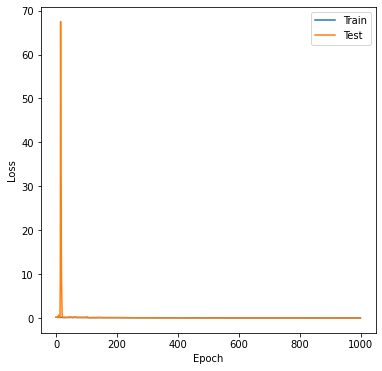

In [ ]:
#train with dataset1
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset2

In [ ]:
#dataset2

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff', 'Movie_HH_15.tiff', 'Movie_HH_35.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif', 'Movie_HH_15_Labels.tif', 'Movie_HH_35_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=400, patch_size=400)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0843 ... Test loss: 0.0766 ... Train IoU: 0.3621 ... Test IoU: 0.4584 ... GPU memory usage: 16225/16280
Epoch 100 ... Training loss: 0.0437 ... Test loss: 0.0633 ... Train IoU: 0.5814 ... Test IoU: 0.4676 ... GPU memory usage: 16225/16280
Epoch 200 ... Training loss: 0.0306 ... Test loss: 0.0366 ... Train IoU: 0.6023 ... Test IoU: 0.587 ... GPU memory usage: 16225/16280
Epoch 300 ... Training loss: 0.0184 ... Test loss: 0.022 ... Train IoU: 0.6599 ... Test IoU: 0.6353 ... GPU memory usage: 16225/16280
Epoch 400 ... Training loss: 0.0096 ... Test loss: 0.0142 ... Train IoU: 0.71 ... Test IoU: 0.6852 ... GPU memory usage: 16225/16280
Epoch 500 ... Training loss: 0.0065 ... Test loss: 0.0083 ... Train IoU: 0.7326 ... Test IoU: 0.7182 ... GPU memory usage: 16225/16280
Epoch 600 ... Training loss: 0.0038 ... Test loss: 0.0043 ... Train

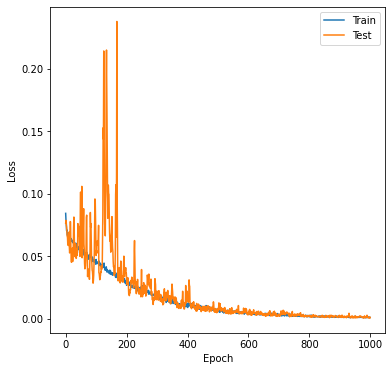

In [ ]:
#train with dataset2
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

train with dataset 3

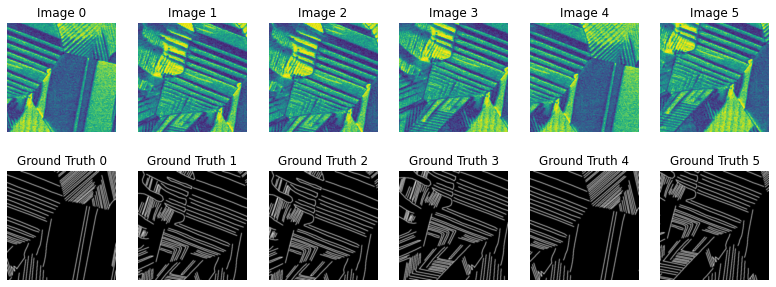

In [ ]:
#dataset3

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size=400)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0833 ... Test loss: 0.0788 ... Train IoU: 0.3601 ... Test IoU: 0.4334 ... GPU memory usage: 16227/16280
Epoch 100 ... Training loss: 0.0368 ... Test loss: 0.0335 ... Train IoU: 0.6251 ... Test IoU: 0.6302 ... GPU memory usage: 16227/16280
Epoch 200 ... Training loss: 0.0219 ... Test loss: 0.0207 ... Train IoU: 0.692 ... Test IoU: 0.7132 ... GPU memory usage: 16227/16280
Epoch 300 ... Training loss: 0.0124 ... Test loss: 0.0118 ... Train IoU: 0.744 ... Test IoU: 0.7475 ... GPU memory usage: 16227/16280
Epoch 400 ... Training loss: 0.0067 ... Test loss: 0.0087 ... Train IoU: 0.7956 ... Test IoU: 0.767 ... GPU memory usage: 16227/16280
Epoch 500 ... Training loss: 0.0042 ... Test loss: 0.0035 ... Train IoU: 0.8352 ... Test IoU: 0.85 ... GPU memory usage: 16227/16280
Epoch 600 ... Training loss: 0.0031 ... Test loss: 0.0028 ... Train 

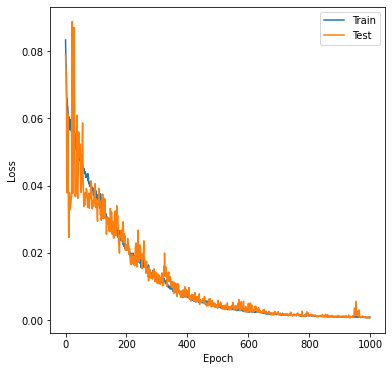

In [ ]:
#train with dataset3
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

train with dataset4

In [ ]:
#dataset4

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,200,200])
ytrain = np.empty([0,200,200])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size=200)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0816 ... Test loss: 0.0795 ... Train IoU: 0.373 ... Test IoU: 0.4193 ... GPU memory usage: 5127/16280
Epoch 100 ... Training loss: 0.0374 ... Test loss: 0.0447 ... Train IoU: 0.6301 ... Test IoU: 0.5493 ... GPU memory usage: 5237/16280
Epoch 200 ... Training loss: 0.0267 ... Test loss: 0.0315 ... Train IoU: 0.6382 ... Test IoU: 0.6428 ... GPU memory usage: 5237/16280
Epoch 300 ... Training loss: 0.017 ... Test loss: 0.0197 ... Train IoU: 0.6823 ... Test IoU: 0.6457 ... GPU memory usage: 5237/16280
Epoch 400 ... Training loss: 0.0108 ... Test loss: 0.0128 ... Train IoU: 0.7092 ... Test IoU: 0.6823 ... GPU memory usage: 5237/16280
Epoch 500 ... Training loss: 0.0083 ... Test loss: 0.0102 ... Train IoU: 0.7091 ... Test IoU: 0.6951 ... GPU memory usage: 5237/16280
Epoch 600 ... Training loss: 0.0068 ... Test loss: 0.0086 ... Train IoU

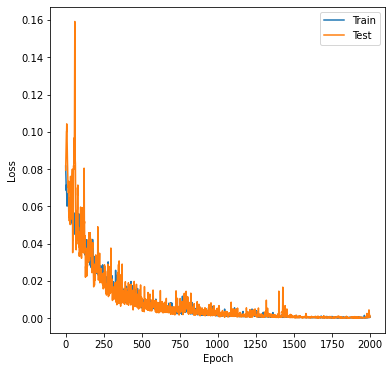

In [ ]:
#train with dataset4
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=2000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

train with dataset5

In [ ]:
#dataset5

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,100,100])
ytrain = np.empty([0,100,100])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size = 100)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0838 ... Test loss: 0.0781 ... Train IoU: 0.365 ... Test IoU: 0.4469 ... GPU memory usage: 2175/16280
Epoch 100 ... Training loss: 0.0506 ... Test loss: 0.0891 ... Train IoU: 0.5351 ... Test IoU: 0.3912 ... GPU memory usage: 2411/16280
Epoch 200 ... Training loss: 0.0343 ... Test loss: 0.0393 ... Train IoU: 0.5878 ... Test IoU: 0.5693 ... GPU memory usage: 2411/16280
Epoch 300 ... Training loss: 0.0294 ... Test loss: 0.03 ... Train IoU: 0.5652 ... Test IoU: 0.5888 ... GPU memory usage: 2411/16280
Epoch 400 ... Training loss: 0.018 ... Test loss: 0.0134 ... Train IoU: 0.6294 ... Test IoU: 0.5722 ... GPU memory usage: 2411/16280
Epoch 500 ... Training loss: 0.0166 ... Test loss: 0.0107 ... Train IoU: 0.5939 ... Test IoU: 0.6913 ... GPU memory usage: 2411/16280
Epoch 600 ... Training loss: 0.0174 ... Test loss: 0.019 ... Train IoU: 0

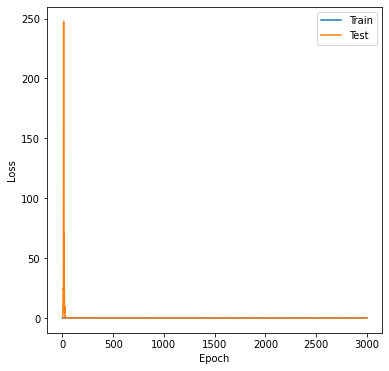

In [ ]:
#train with dataset5
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=3000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset6

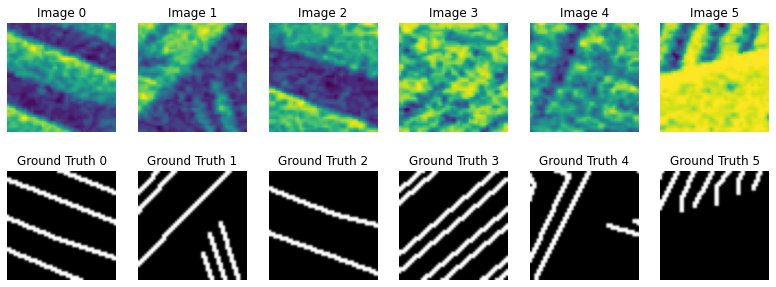

In [ ]:
#dataset6

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,50,50])
ytrain = np.empty([0,50,50])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size = 50)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0845 ... Test loss: 0.0802 ... Train IoU: 0.3432 ... Test IoU: 0.3909 ... GPU memory usage: 1549/16280
Epoch 100 ... Training loss: 0.0539 ... Test loss: 0.0599 ... Train IoU: 0.494 ... Test IoU: 0.4299 ... GPU memory usage: 1709/16280
Epoch 200 ... Training loss: 0.0391 ... Test loss: 0.0485 ... Train IoU: 0.4894 ... Test IoU: 0.4855 ... GPU memory usage: 1709/16280
Epoch 300 ... Training loss: 0.0395 ... Test loss: 0.0185 ... Train IoU: 0.5008 ... Test IoU: 0.6228 ... GPU memory usage: 1709/16280
Epoch 400 ... Training loss: 0.0204 ... Test loss: 0.0369 ... Train IoU: 0.5696 ... Test IoU: 0.5594 ... GPU memory usage: 1709/16280
Epoch 500 ... Training loss: 0.0135 ... Test loss: 0.0211 ... Train IoU: 0.6204 ... Test IoU: 0.4896 ... GPU memory usage: 1709/16280
Epoch 600 ... Training loss: 0.0288 ... Test loss: 0.0103 ... Train Io

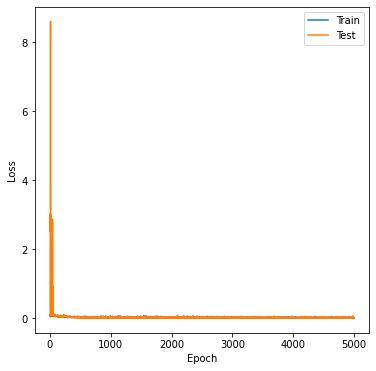

In [ ]:
#train with dataset6
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=5000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

train with dataset7

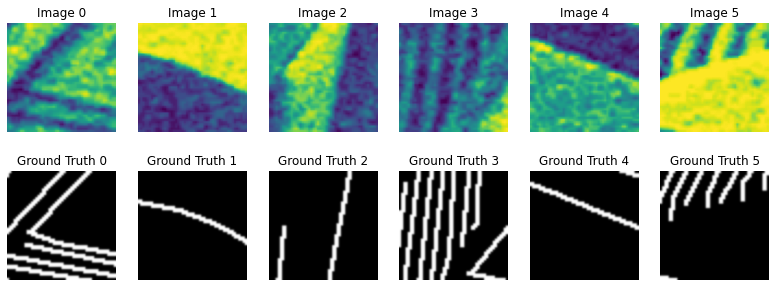

In [ ]:
#dataset7

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,50,50])
ytrain = np.empty([0,50,50])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=3600, patch_size = 50)                       #triple numpatch
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0886 ... Test loss: 0.0779 ... Train IoU: 0.3457 ... Test IoU: 0.4541 ... GPU memory usage: 2309/16160
Epoch 100 ... Training loss: 0.0547 ... Test loss: 0.0704 ... Train IoU: 0.5077 ... Test IoU: 0.4555 ... GPU memory usage: 2487/16160
Epoch 200 ... Training loss: 0.0452 ... Test loss: 0.041 ... Train IoU: 0.5069 ... Test IoU: 0.5281 ... GPU memory usage: 2487/16160
Epoch 300 ... Training loss: 0.0299 ... Test loss: 0.0261 ... Train IoU: 0.5609 ... Test IoU: 0.5621 ... GPU memory usage: 2487/16160
Epoch 400 ... Training loss: 0.0191 ... Test loss: 0.0389 ... Train IoU: 0.613 ... Test IoU: 0.5446 ... GPU memory usage: 2487/16160
Epoch 500 ... Training loss: 0.0203 ... Test loss: 0.0157 ... Train IoU: 0.534 ... Test IoU: 0.5388 ... GPU memory usage: 2487/16160
Epoch 600 ... Training loss: 0.0259 ... Test loss: 0.0062 ... Train IoU:

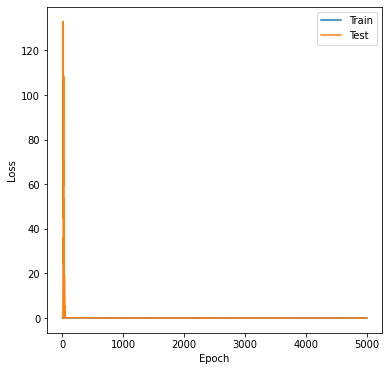

In [ ]:
#train with dataset7
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=5000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

# **Test the model using validation data**


*   Make predictions on the validation data sets 
*   A comparison of predictions with ground truth shows that predicted wall maps are well consistent with ground truth



In [ ]:
!gdown https://drive.google.com/uc?id=1Ra5cKUYsF4GYSRgmShMDDZ3reLgL2srH
!gdown https://drive.google.com/uc?id=1-Bwtv092tG9CNBjUx23QO1jgJHlMNG_O
!gdown https://drive.google.com/uc?id=1-JF8C9r0sEIbUU0HD-FKbkTShVPSrqBl
!gdown https://drive.google.com/uc?id=1FIrpU5hxgdHIN-nloMMEw7vf0pM3GWxz
!gdown https://drive.google.com/uc?id=1-0WALRM1-hKQD82P03HhSPfCdThQ-khT
!gdown https://drive.google.com/uc?id=1-3gR0U0Zrg10UgPbRAHBN2nMQTMhLMZ2
!gdown https://drive.google.com/uc?id=1b7STQKqw-UFzfpeHb8n0kXhlGS12Z9w-

Downloading...
From: https://drive.google.com/uc?id=1Ra5cKUYsF4GYSRgmShMDDZ3reLgL2srH
To: /content/drive/My Drive/Model/Ferroelectric_DW_dynamics_Notebook4_2_Dataset1_withoutgroup_metadict_final_weights.tar
91.0MB [00:00, 94.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Bwtv092tG9CNBjUx23QO1jgJHlMNG_O
To: /content/drive/My Drive/Model/Ferroelectric_DW_dynamics_Notebook4_2_Dataset2_withoutgroup_metadict_final_weights.tar
91.0MB [00:01, 81.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-JF8C9r0sEIbUU0HD-FKbkTShVPSrqBl
To: /content/drive/My Drive/Model/Ferroelectric_DW_dynamics_Notebook4_2_Dataset3_withoutgroup_metadict_final_weights.tar
91.0MB [00:00, 94.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FIrpU5hxgdHIN-nloMMEw7vf0pM3GWxz
To: /content/drive/My Drive/Model/Ferroelectric_DW_dynamics_Notebook4_2_Dataset4_withoutgroup_metadict_final_weights.tar
91.0MB [00:01, 62.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0WALRM1-hKQD82P03H

Download and load test data

In [ ]:
!gdown https://drive.google.com/uc?id=1-ZtgJ7y6L9BKQtaQYmz3ePtvZszOn_vO
data_test = np.load('hed_test_data.npz')
xtest = data_test['imgs'][:, None, ...]; ytest = data_test['labs'][:, None, ...] 

Load ResHed weight

In [ ]:
trained_model = hednet()
weights = torch.load('Ferroelectric_DW_dynamics_Notebook4_2_Dataset7_withoutgroup_metadict_final_weights.tar')["weights"]   #load the weight you want to check
trained_model.load_state_dict(weights)
# trained_model.eval()

<All keys matched successfully>

Make precition on validation images and compare with ground truth

In [ ]:
p = aoi.atomnet.predictor(trained_model, use_gpu=True)
prediction, _ = p.run(xtest)

/usr/local/lib/python3.7/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 50/50
50 images were decoded in approximately 12.8447 seconds


Text(0.5, 1.0, 'NGHED Prediction')

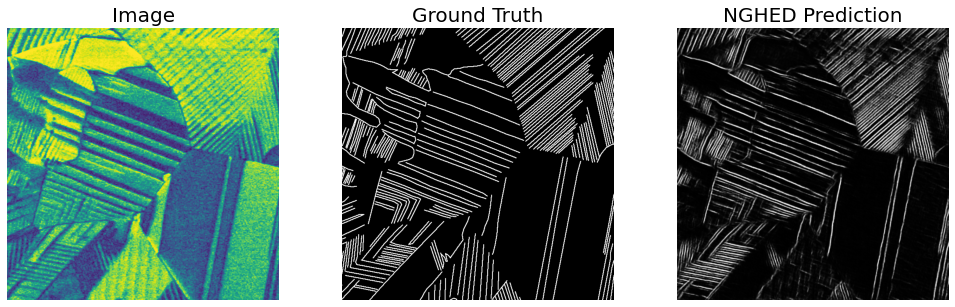

In [ ]:
k = 1
_,(ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(17, 5))
ax0.imshow(xtest[k, 0])
ax0.axis ('off')
ax0.set_title('Image', fontsize = 20)
ax1.imshow(ytest[k, 0], cmap = 'gray')
ax1.axis('off')
ax1.set_title('Ground Truth', fontsize = 20)
ax2.imshow(prediction[k,...,0], cmap = 'gray')
ax2.axis('off')
ax2.set_title('NGHED Prediction', fontsize = 20)